# Model Testing
This notebook tests the models created in "Model Training".

## Imports


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft, istft
import tensorflow as tf
from ipywidgets import interact
from code.stftprocessing import StftDataset
from code.dsvisual import DatasetVisualizer
from tqdm import tqdm
import datetime


2023-03-29 14:10:14.408887: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


## Load the model
Load the model stored at the _model_path_.

In [1]:
model_path = "model/model-28-03-2023"
new_model_path = "model/model-29-03-h1401-p2941361"

In [3]:
model = tf.keras.models.load_model(model_path)
new_model = tf.keras.models.load_model(new_model_path)

2023-03-29 14:10:31.494375: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-03-29 14:10:31.524810: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-03-29 14:10:31.579687: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-29 14:10:31.579948: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:04:00.0 name: NVIDIA GeForce GTX 970 computeCapability: 5.2
coreClock: 1.253GHz coreCount: 13 deviceMemorySize: 3.93GiB deviceMemoryBandwidth: 208.91GiB/s
2023-03-29 14:10:31.579977: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-03-29 14:10:31.771787: I tensorflow/stream_executor/platform/def

## Processing input to the model
The model takes STFT amplitude data.

Write a function that processes a waveform so that it is usable by the model.

In [45]:
def denoise_waveform(waveform, model=model, fs = 0.2):
    # process into STFT
    f,t, result_stft = stft(waveform, fs =fs)

    # get the amplitude
    amp = np.absolute(result_stft)
    phase = np.angle(result_stft)
    # reshape for model
    amp_reshaped = amp.reshape((1, amp.shape[0], amp.shape[1]))
    
    # model predict
    result = model.predict(amp_reshaped)
    
    # process data from STFT into time domain form
    t, signal = istft(result*np.exp(1j*phase), fs = fs)
    signal = signal.reshape(signal.shape[1])
    return signal

## Load the data
Load the time domain waveform data.

In [77]:
data_folder = "data/q3/"


In [79]:
waveforms = np.load(data_folder + "full_waveform_data.npy")
num_waveforms = waveforms.shape[0]

In [80]:
test_waveform = waveforms[4]

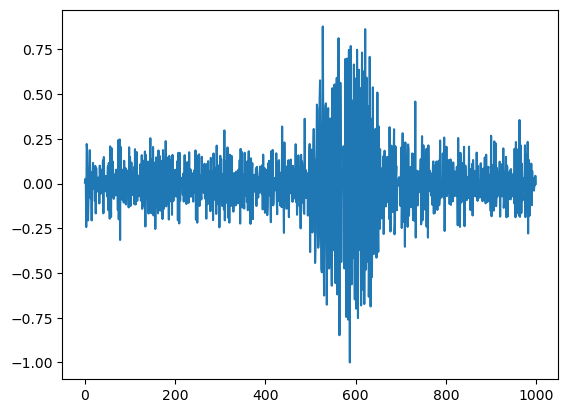

In [81]:
plt.plot(test_waveform)

In [82]:
denoised_waveform = denoise_waveform(test_waveform)

In [83]:
denoised_waveform.shape

(1024,)

In [86]:
def plot_denoise(index):
    current_waveform = waveforms[index]
    denoised_waveform = denoise_waveform(current_waveform)
    
    fig, [ax1, ax2] = plt.subplots(1,2)
    fig.set_size_inches((12,10))
    ax1.plot(current_waveform)
    ax1.plot(denoised_waveform, alpha=0.4)
    ax2.plot(current_waveform - denoised_waveform[:1000])
    plt.show()

In [87]:
interact(plot_denoise, index=(0,num_waveforms, 1))

interactive(children=(IntSlider(value=80, description='index', max=160), Output()), _dom_classes=('widget-inte…

<function __main__.plot_denoise(index)>